In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import sys

sys.path.insert(0, "/Users/flynnwang/repo/flynn/eco_bang_bang")

In [3]:
from ebb.env.const import *

In [4]:
from ebb.env import LuxS3Env


env = LuxS3Env(reward_schema='game_win_loss2', reward_shaping_params={'use_mirror': False,
                                                                      'use_hidden_relic_estimator': True})

obs, reward, done, info = env.reset()

In [5]:
PLAYER_ID = 0

ob = obs[PLAYER_ID]
len(ob.keys()), ob.keys()

(34,
 dict_keys(['unit_move_cost', 'unit_sensor_range', 'unit_sap_cost', 'unit_sap_range', 'nebula_energy_reduction', 'game_step', 'match_step', 'units_team_points', 'enemy_team_points', 'units_team_points_delta', 'enemy_team_points_delta', 'units_wins', 'enemy_wins', 'cell_type', 'nebula_tile_vision_reduction', 'vision_map', 'visible', 'match_observed', 'match_visited', 'game_visited', 'is_relic_node', 'game_unvisited_relic_nb', 'team_point_prob', 'cell_energy', 'units_loc_t0', 'units_energy_t0', 'units_loc_t1', 'units_energy_t1', 'enemy_loc_t0', 'enemy_energy_t0', 'enemy_loc_t1', 'enemy_energy_t1', '_units_info', '_baseline_extras']))

In [6]:
OB_KEYS = list(ob.keys())

In [7]:
from agents.shaping_reward_0110.shaping_reward_0110.agent import Agent

# Simple Agent

In [8]:
import numpy as np

 #   direction (0 = center, 1 = up, 2 = right, 3 = down, 4 = left)
def direction_to(src, target):
    ds = target - src
    dx = ds[0]
    dy = ds[1]
    if dx == 0 and dy == 0:
        return 0
    if abs(dx) > abs(dy):
        if dx > 0:
            return 2 
        else:
            return 4
    else:
        if dy > 0:
            return 3
        else:
            return 1


class Agent():
    def __init__(self, player: str, env_cfg) -> None:
        self.player = player
        self.opp_player = "player_1" if self.player == "player_0" else "player_0"
        self.team_id = 0 if self.player == "player_0" else 1
        self.opp_team_id = 1 if self.team_id == 0 else 0
        np.random.seed(0)
        self.env_cfg = env_cfg
        
        self.relic_node_positions = []
        self.discovered_relic_nodes_ids = set()
        self.unit_explore_locations = dict()

    def act(self, step: int, obs, remainingOverageTime: int = 60):
        """implement this function to decide what actions to send to each available unit. 
        
        step is the current timestep number of the game starting from 0 going up to max_steps_in_match * match_count_per_episode - 1.
        """
        unit_mask = np.array(obs["units_mask"][self.team_id]) # shape (max_units, )
        unit_positions = np.array(obs["units"]["position"][self.team_id]) # shape (max_units, 2)
        unit_energys = np.array(obs["units"]["energy"][self.team_id]) # shape (max_units, 1)
        observed_relic_node_positions = np.array(obs["relic_nodes"]) # shape (max_relic_nodes, 2)
        observed_relic_nodes_mask = np.array(obs["relic_nodes_mask"]) # shape (max_relic_nodes, )
        team_points = np.array(obs["team_points"]) # points of each team, team_points[self.team_id] is the points of the your team
        
        # ids of units you can control at this timestep
        available_unit_ids = np.where(unit_mask)[0]
        # visible relic nodes
        visible_relic_node_ids = set(np.where(observed_relic_nodes_mask)[0])
        
        actions = np.zeros((self.env_cfg["max_units"], 3), dtype=int)


        # basic strategy here is simply to have some units randomly explore and some units collecting as much energy as possible
        # and once a relic node is found, we send all units to move randomly around the first relic node to gain points
        # and information about where relic nodes are found are saved for the next match
        
        # save any new relic nodes that we discover for the rest of the game.
        for id in visible_relic_node_ids:
            if id not in self.discovered_relic_nodes_ids:
                self.discovered_relic_nodes_ids.add(id)
                self.relic_node_positions.append(observed_relic_node_positions[id])
            

        # unit ids range from 0 to max_units - 1
        for unit_id in available_unit_ids:
            unit_pos = unit_positions[unit_id]
            unit_energy = unit_energys[unit_id]
            if len(self.relic_node_positions) > 0:
                nearest_relic_node_position = self.relic_node_positions[0]
                manhattan_distance = abs(unit_pos[0] - nearest_relic_node_position[0]) + abs(unit_pos[1] - nearest_relic_node_position[1])
                
                # if close to the relic node we want to hover around it and hope to gain points
                if manhattan_distance <= 4:
                    random_direction = np.random.randint(0, 5)
                    actions[unit_id] = [random_direction, 0, 0]
                else:
                    # otherwise we want to move towards the relic node
                    actions[unit_id] = [direction_to(unit_pos, nearest_relic_node_position), 0, 0]
            else:
                # randomly explore by picking a random location on the map and moving there for about 20 steps
                if step % 20 == 0 or unit_id not in self.unit_explore_locations:
                    rand_loc = (np.random.randint(0, self.env_cfg["map_width"]), np.random.randint(0, self.env_cfg["map_height"]))
                    self.unit_explore_locations[unit_id] = rand_loc
                actions[unit_id] = [direction_to(unit_pos, self.unit_explore_locations[unit_id]), 0, 0]
        #return actions

        # convert actions into simple moves
        aa = np.zeros((self.env_cfg["max_units"], 1), dtype=int)
        for i, (a, x, y) in enumerate(actions):
            a = min(a, 4)
            aa[i] = a
        return aa


# Feature Plots

In [9]:
def plot_imgs(images):
    grid_size = 3
    fig, axes = plt.subplots(grid_size + 1, grid_size, figsize=(10, 10))
    
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            name, img = images[i]
            img = img.T
            ax.imshow(img, cmap='viridis')  # Display image (grayscale here)
            ax.set_title(name, fontsize=8)
            ax.axis('off')  # Turn off the axes
            ax.set_xticks(np.arange(-0.5, img.shape[1], 1))  # Position gridlines at the edges of the pixels
            ax.set_yticks(np.arange(-0.5, img.shape[0], 1))  # Position gridlines at the edges of the pixels
            # Set gridlines to be visible
            ax.grid(which='both', color='black', linestyle='-', linewidth=.5)
        else:
            ax.axis('off')  # Turn off the axes for empty slots
    
    plt.tight_layout()
    plt.show()

In [10]:
from ebb.env import LuxS3Env


env = LuxS3Env(reward_schema='game_win_loss2', reward_shaping_params={'use_mirror': False,
                                                                      'use_hidden_relic_estimator': True})

obs, reward, done, info = env.reset(seed=1331520750)

In [11]:
def act(a, ob):
    player_id = a.player
    step = ob['steps']
    actions = a.act(step, ob)
    return actions

env_cfg = env.mms[0].env_cfg
a0 = Agent('player_0', env_cfg)
a1 = Agent('player_1', env_cfg)

[[17  0]
 [17  4]
 [18  0]
 [18  1]
 [19  3]] [array([17,  4]), array([18,  0]), array([18,  1]), array([19,  3])] 1
[[17  0]
 [17  4]
 [18  0]
 [18  1]
 [19  3]] [array([17,  0]), array([18,  0]), array([18,  1]), array([19,  3])] 1
[[17  0]
 [17  4]
 [18  0]
 [18  1]
 [19  3]] [array([17,  0]), array([17,  4]), array([18,  1]), array([19,  3])] 1
[[17  0]
 [17  4]
 [18  0]
 [18  1]
 [19  3]] [array([17,  0]), array([17,  4]), array([18,  0]), array([19,  3])] 1
[[17  0]
 [17  4]
 [18  0]
 [18  1]
 [19  3]] [array([17,  0]), array([17,  4]), array([18,  0]), array([18,  1])] 1
[[ 1 21]
 [ 4 21]
 [ 5 21]
 [ 5 22]
 [ 5 23]
 [ 6 23]] [array([ 4, 21]), array([ 5, 21]), array([ 5, 22]), array([ 5, 23]), array([ 6, 23])] 3
[[ 1 21]
 [ 4 21]
 [ 5 21]
 [ 5 22]
 [ 5 23]
 [ 6 23]] [array([ 1, 21]), array([ 5, 21]), array([ 5, 22]), array([ 5, 23]), array([ 6, 23])] 3
[[ 1 21]
 [ 4 21]
 [ 5 21]
 [ 5 22]
 [ 5 23]
 [ 6 23]] [array([ 1, 21]), array([ 4, 21]), array([ 5, 22]), array([ 5, 23]), array

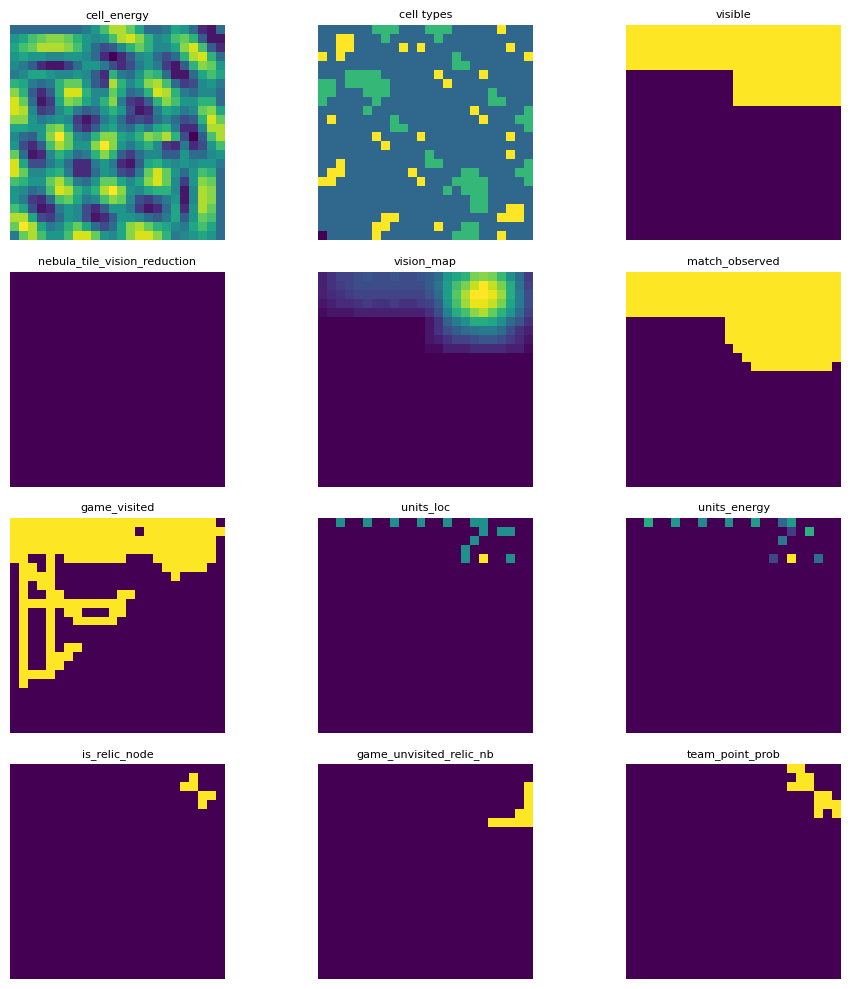

In [35]:
for i in range(30):
    action0 = act(a0, env.mms[0].past_obs[0])
    action1 = act(a1, env.mms[1].past_obs[0])
    player_actions = [{UNITS_ACTION: action0}, {UNITS_ACTION: action1}]
    obs, reward, done, info = env.step(player_actions)

ob = obs[PLAYER_ID]
ob['game_step'][0][0][0], ob['match_step'][0][0][0]

# action0 = act(a0, env.mms[0].past_obs[0])
# action1 = act(a1, env.mms[1].past_obs[0])
# player_actions = [{UNITS_ACTION: action0}, {UNITS_ACTION: action1}]
# obs, reward, done, info = env.step(player_actions)

# ob = obs[PLAYER_ID]
print(ob['game_step'][0][0][0] * 505, ob['match_step'][0][0][0] * 100)

units_loc = ob['units_loc_t0']
units_energy = ob['units_energy_t0']

nebula_tile_vision_reduction = ob['nebula_tile_vision_reduction']

nu = env.mms[0].past_obs[0]['units_mask'][0].sum()
print(f'number of units: {nu}')
plot_imgs([('cell_energy', ob['cell_energy']), ('cell types', ob['cell_type']), ('visible', ob['visible']),
           
                       ('nebula_tile_vision_reduction', nebula_tile_vision_reduction),
           ('vision_map', ob['vision_map']),
           ('match_observed', ob['match_observed']), ('game_visited', ob['game_visited']),
           ('units_loc', units_loc),  ('units_energy', units_energy),
           ('is_relic_node', ob['is_relic_node']),
           ('game_unvisited_relic_nb', ob['game_unvisited_relic_nb']), ('team_point_prob', ob['team_point_prob']),
           ])

In [26]:
len(env.mms[0].hidden_relic_estimator.priori[env.mms[0].hidden_relic_estimator.priori > 0.002])

29

In [30]:
env.mms[0].hidden_relic_estimator.priori[env.mms[0].hidden_relic_estimator.priori > 0.002]

array([0.25      , 0.01883892, 0.999     , 0.999     , 0.999     ,
       0.25      , 0.25      , 0.54857891, 0.75      , 0.00539318,
       0.25      , 0.25      , 0.64485333, 0.999     , 0.999     ,
       0.25      , 0.03691697, 0.01145847, 0.01891216, 0.48500227,
       0.99700599, 0.25      , 0.25      , 0.18980835, 0.25      ,
       0.25      , 0.25      , 0.25      , 0.25      ])